In [1]:
%matplotlib widget
import pandas as pd
import numpy as np
from obspy.core.utcdatetime import UTCDateTime
from obspy.clients.fdsn import Client

## Collecting USGS data in Hawaii

In [3]:
ref_location = 19.485901834882345, -155.30471152157713
startdate = UTCDateTime('1988-01-01')
enddate = UTCDateTime('2024-09-01')
offset = 1.
minmagnitude = 3.
maxdepth = 15.

opt_catalog = dict(
    starttime = startdate,
    endtime = enddate,
    maxlongitude = min(ref_location[1]+offset, 180.),
    maxlatitude = min(ref_location[0]+offset, 90.),
    minlongitude = max(ref_location[1]-offset, -180.),
    minlatitude = max(ref_location[0]-offset, -90.),
    minmagnitude=minmagnitude, 
    maxdepth=maxdepth,
    includeallorigins=True,
    #includearrivals=True
)
    
client = Client("USGS")
catalog = client.get_events(**opt_catalog)
print(catalog)

3587 Event(s) in Catalog:
2024-08-29T06:22:50.350000Z | +20.119, -155.414 | 3.01 ml | manual
2024-08-23T09:03:39.560000Z | +19.389, -155.244 | 3.07 ml | manual
...
1988-02-10T13:26:57.660000Z | +19.358, -155.043 | 3.04 ml | manual
1988-01-27T01:24:35.990000Z | +19.338, -155.063 | 3.93 ml | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [10]:
mags = np.array([ev.magnitudes[0].mag for ev in catalog])
id_large = np.argmax(mags)
#catalog[id_large]
nb_mt = np.array([len(ev.focal_mechanisms) for ev in catalog])
id_mt = np.where(nb_mt>0)[0]
catalog[id_mt[0]].focal_mechanisms[0].moment_tensor.tensor['m_rr']

5970000000000000.0

In [28]:
from tqdm import tqdm

depths = [ev.origins[0].depth/1e3 for ev in catalog]
mags = [ev.magnitudes[0].mag for ev in catalog]
times = [(ev.origins[0].time - startdate)/(3600*24*365) for ev in catalog]
UTC_times = [ev.origins[0].time.datetime for ev in catalog]
#mrr = [ev.focal_mechanisms[0].moment_tensor.tensor.m_rr for ev in catalog if ev.focal_mechanisms else np.nan]

l_comp_tensor = {'m_rr': np.nan, 'm_tt': np.nan, 'm_pp': np.nan, 'm_rt': np.nan, 'm_rp': np.nan, 'm_tp': np.nan}
catalog_hawai = pd.DataFrame()
for ev in tqdm(catalog):
    loc_dict = l_comp_tensor.copy()
    if ev.focal_mechanisms: 
        if ev.focal_mechanisms[0].moment_tensor is not None:
            for comp in loc_dict:
                try:
                    loc_dict[comp] = ev.focal_mechanisms[0].moment_tensor.tensor[comp]
                except:
                    print(f'Error: {ev.focal_mechanisms[0].moment_tensor}')
    catalog_hawai = pd.concat([catalog_hawai, pd.DataFrame([loc_dict])])

#catalog_hawai = pd.DataFrame(np.array([pd.to_datetime(UTC_times), times, depths, mags]).T, columns=['UTC', 'time (years)', 'depth', 'mag'])
catalog_hawai[['UTC', 'time (years)', 'depth', 'mag']] = np.array([pd.to_datetime(UTC_times), times, depths, mags]).T
catalog_hawai.sort_values(by='time (years)', inplace=True)
catalog_hawai.to_csv('./data/hawai_catalog.csv', header=True, index=False)

  0%|          | 0/3587 [00:00<?, ?it/s]

100%|██████████| 3587/3587 [00:05<00:00, 629.63it/s]


## Test plotting sequence information

In [2]:
catalog_hawai = pd.read_csv('./data/hawai_catalog.csv', header=[0])
catalog_hawai.loc[:,'UTC'] = pd.to_datetime(catalog_hawai.UTC)
catalog_hawai = catalog_hawai.loc[catalog_hawai.mag>=3.]

all_mags = catalog_hawai.mag.values
all_times = catalog_hawai['time (years)'].values

c:\Users\quentin\Documents\2024_Venus_Detectability\proba_volcanoes_modules.py:262: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax_zoom.set_title(f'Collapse events in 2018')


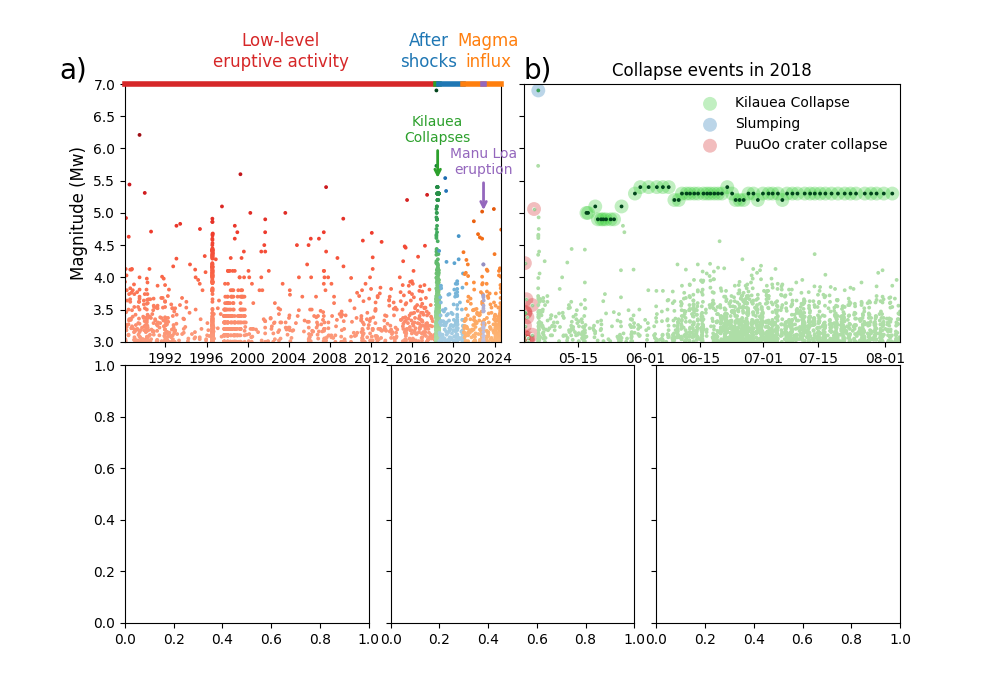

In [13]:
from importlib import reload
import matplotlib.pyplot as plt
import proba_volcanoes_modules as pvm
reload(pvm)

fig = plt.figure(figsize=(10,7))
grid = fig.add_gridspec(4, 6)

ax_first = fig.add_subplot(grid[:2,:3])
ax_zoom = fig.add_subplot(grid[:2,3:], sharey=ax_first)

ax = fig.add_subplot(grid[2:,0:2],)
ax = fig.add_subplot(grid[2:,2:4], sharey=ax)
ax.tick_params(axis='both', labelleft=False)
ax = fig.add_subplot(grid[2:,4:], sharey=ax)
ax.tick_params(axis='both', labelleft=False)

pvm.plot_sequence_events(fig, ax_first, ax_zoom, catalog_hawai, max_val=7., fontsize=12., fontsize_label=20.)
fig.savefig('./figures/Figure_4_volcanoes.pdf')